In [251]:
#imports
import numpy as np
import sklearn
from skimage import morphology
import cv2
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.transform import rotate
from sklearn.cluster import KMeans

imgDir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "data/lesion_imgs"))
maskDir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "data/lesion_masks"))

# Approach 1: Simple Difference of average pixel intensities
### The method extracts the average color of the center of the lesion. It then computes the average color of the outer part of each of the 8 segments.
### A sector is labeled as "well-pronounced" if the difference of it's average color to the outside color(color outside the lesion mask) is at least 80% of the difference between the average color of the lesion center and the average color of the outside color. Also the difference should be at least 20 for the sector to be labeled as "well-pronounced".
### -> the method returns 0 (none of the sectors are well-pronounced) to 8 (all 8 sectors are well-pronounced)
### The idea is that fading sectors have an average color much closer to the skin color than the center of the lesion does, so they will not exceed the aforementioned threshold.


181.20346866883682
102.5484668644906
78.65500180434621


122.83196867212531
125.52425373134328
112.271034996277
122.27854671280276
137.9605795148248
142.05424810530513
129.89350838803793
112.60043907793633


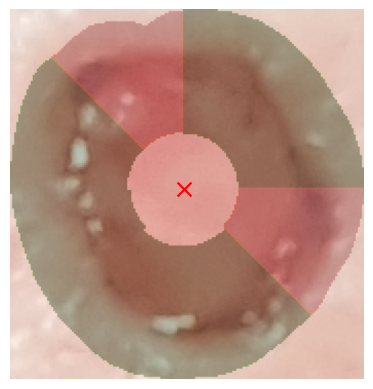

[58.371499996711506, 55.67921493749354, 68.93243367255982, 58.924921956034055, 43.24288915401203, 39.149220563531685, 51.30996028079889, 68.60302959090049]
Irregular Border: 2


In [252]:
def find_midpoint_v4(mask):
        """Finds horizontal and vertical midpoints of the given binary
        mask, such that 50% of nonzero pixels in the mask
        are on either side of midpoint.

        :param mask: Binary Mask to be examined.
        :return x, y: coordinates of midpoint."""
        mX = 0
        mY = 0
        #get horizontal vector which contains number of nonzero pixels for each mask column
        summedX = np.sum(mask, axis=0)
        #calculate 50% of nonzero pixels in mask as threshold
        half_sumX = np.sum(summedX) / 2
        #iterate through columns until half of nonzero pixels in mask have been reached
        for i, n in enumerate(np.add.accumulate(summedX)):
            if n > half_sumX:
                #x-coordinate at which 50% of nonzero pixels where exceeded
                mX = i
                break
        
        summedY = np.sum(mask, axis=1)
        #calculate 50% of nonzero pixels in mask as threshold
        half_sumY = np.sum(summedY) / 2
        #iterate through rows until half of nonzero pixels in mask have been reached
        for i, n in enumerate(np.add.accumulate(summedY)):
            if n > half_sumY:
                # y-coordinate at which 50% of nonzero pixels where exceeded
                mY = i
                break

        return mX, mY

def scale_mask(mask, center, scale_factor=0.9):
    """
    Scale a binary mask around a center point.
    
    :param mask: Input binary mask (2D NumPy array).
    :param center: Tuple (x, y) - center of scaling.
    :param scale_factor: Scaling factor (e.g., 0.9 for shrink).
    :return: Scaled binary mask.
    """
    h, w = mask.shape
    cx, cy = center

    # Create transformation matrix for scaling around (cx, cy)
    M = cv2.getRotationMatrix2D((cx, cy), angle=0, scale=scale_factor)

    # Apply affine transformation
    scaled_mask = cv2.warpAffine(mask.astype(np.uint8), M, (w, h), flags=cv2.INTER_NEAREST)

    return scaled_mask
        

def cut_mask(mask):
    
    # input is numpy array mask
    col_sums = np.sum(mask, axis=0)     # sums up the values between 0 and 1
    row_sums = np.sum(mask, axis=1)     # shows if any row or column contains anything but 0s

    active_cols = []        # lists all the columns where there is no lesion
    for index, col_sum in enumerate(col_sums):  # takes all columns
        if col_sum != 0:                        # if the full column is 0, it's not added to the list
            active_cols.append(index)

    active_rows = []        # analog for rows
    for index, row_sum in enumerate(row_sums):
        if row_sum != 0:
            active_rows.append(index)

    # taking the bordering rows and columns of the mask (excluding the black edges where there is nothing)
    col_min = active_cols[0]
    col_max = active_cols[-1]
    row_min = active_rows[0]
    row_max = active_rows[-1]

    # saving the new mask
    cut_mask_ = mask[row_min:row_max+1, col_min:col_max+1]

    return cut_mask_

def cut_im_by_mask(image, mask):
    # same as previous function
    col_sums = np.sum(mask, axis=0)
    row_sums = np.sum(mask, axis=1)

    active_cols = []
    for index, col_sum in enumerate(col_sums):
        if col_sum != 0:
            active_cols.append(index)

    active_rows = []
    for index, row_sum in enumerate(row_sums):
        if row_sum != 0:
            active_rows.append(index)

    col_min = active_cols[0]
    col_max = active_cols[-1]
    row_min = active_rows[0]
    row_max = active_rows[-1]

    #except the cutting is applied to the image itself and not the mask
    cut_image = image[row_min:row_max+1, col_min:col_max+1]

    return cut_image

def getSectorMask(mask, angleStart, angleEnd, mX, mY):
    # Get image dimensions
    height, width = mask.shape[:2]

    # Create coordinate grid
    Y, X = np.ogrid[:height, :width]
    dx = X - mX
    dy = mY - Y  # inverted Y to make 0° at the top (like a clock)

    # Compute angle in degrees (0° at top, increasing clockwise)
    angles = (np.degrees(np.arctan2(dx, dy)) + 360) % 360

    # Create mask for angles between angleStart and angleEnd
    mask = (angles >= angleStart) & (angles < angleEnd)

    return mask

def irregularBorder(imgColor, mask, nSectors=8) -> int:
    """Extract the \"irregular Boder\" feature,
    which is a number from 0 to 1 that is a measure
    for the difference between the center intensity
    and border intensity of the lesion.
    
    :param img: the image to process
    :param mask: mask to apply to the image
    :return: border irregularity measure from
    0(regular) to 1(irregular)"""
    img = cv2.cvtColor(imgColor, cv2.COLOR_RGB2GRAY)
    outsideMask = cv2.bitwise_not(mask)
    outsideMask = outsideMask > 0
    avgOutsideColor = np.mean(img[outsideMask], axis=0)
    print(avgOutsideColor)

    cutImg = cut_im_by_mask(img, mask)
    cutImgColor = cut_im_by_mask(imgColor, mask)
    cutMask = cut_mask(mask)
    mX, mY = find_midpoint_v4(cutMask)

    #scale mask to 0.5 size to extract center color
    scaledMask = scale_mask(cutMask, (mX, mY), 0.5)
    scaledMask = scaledMask > 0
    avgInsideColor = np.mean(cutImg[scaledMask], axis=0)
    print(avgInsideColor)
    avgDiff = abs(avgInsideColor - avgOutsideColor)
    print(avgDiff)
    print("\n")

    #store difference values for the sectors
    diffScores = []

    #these are only for visualization purposes
    pronouncedMask = np.zeros(cutMask.shape, dtype=np.uint8)
    fadedMask = np.zeros(cutMask.shape, dtype=np.uint8)

    sectorDeg = int(np.ceil(360 / nSectors))
    for deg in range(0, 360, sectorDeg):
        sectorMask = (getSectorMask(cutMask, deg, deg+sectorDeg, mX, mY) & cutMask)#extract current sector (only where lesion is)
        #extract only border points in that sector
        y_nonzero, x_nonzero = np.nonzero(sectorMask)#get vectors of x-values & y-values of nonzero points (x&y reversed by numpy)
        dX = x_nonzero - mX#get vector of x-distances from points to middle
        dY = y_nonzero - mY#get vector of y-distances from points to middle
        dist = np.sqrt(dX**2 + dY**2)#compute distances for all of these points
        maxDist = np.max(dist)#get maximum distance
        distFar = maxDist*0.3#set inner threshold for border pixels
        idcBorder = np.where(dist > distFar)#extract indices for points that exceed the distance threshold
        borderMask = np.zeros(cutMask.shape, dtype=np.uint8)#create mask for border pixels
        borderMask[y_nonzero[idcBorder], x_nonzero[idcBorder]] = 1#use index obtained earlier to obtain coordinates of points exceeding the distance (again, x&y reversed because of numpy)
        
        borderMask = borderMask > 0
        avgColor = np.mean(cutImg[borderMask], axis=0)
        print(avgColor)
        diffScores.append(abs(avgColor - avgOutsideColor))

        #for visualization purposes
        if diffScores[-1] > (0.8*avgDiff) and diffScores[-1] > 20:
            pronouncedMask[y_nonzero[idcBorder], x_nonzero[idcBorder]] = 1
        else:
            fadedMask[y_nonzero[idcBorder], x_nonzero[idcBorder]] = 1

    plt.imshow(cutImgColor)
    plt.imshow(pronouncedMask, cmap="Reds", alpha=0.3)
    plt.imshow(fadedMask, cmap="Greens", alpha=0.3)
    plt.scatter(mX, mY, c="red", marker="x", s=100)
    plt.axis("off")
    plt.show()
    
    wellPronounced = 0
    for score in diffScores:
        if score > (0.8*avgDiff) and score > 20:
            wellPronounced += 1

    print(diffScores)
    return wellPronounced


#imName = "PAT_72_110_647.png"
#imName = "PAT_20_30_44.png"
#imName = "PAT_83_126_820.png"
imName = "PAT_90_138_369.png"#good test case to show where it goes wrong -> if the mask doesn't fit properly, then it's fucked -> too high
#imName = "PAT_173_268_1000.png"#another example of a not-so spot on mask -> too high
#imName = "PAT_187_287_482.png"#kinda okay
#imName = "PAT_320_681_410.png"#kinda okay
#imName= "PAT_333_702_840.png"
#imName = "PAT_364_748_278.png"
#imName = "PAT_615_1167_722.png"
#imName = "PAT_263_403_966.png"
#imName = "PAT_270_1382_561.png"
maskName = imName.split(".")[0] + "_mask" + ".png"
testImg = cv2.imread(os.path.join(imgDir, imName))
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
testMask = cv2.imread(os.path.join(maskDir, maskName), cv2.IMREAD_GRAYSCALE)
_, testMask = cv2.threshold(testMask, 127, 255, cv2.THRESH_BINARY)

print(f"Irregular Border: {irregularBorder(testImg, testMask)}")

# Approach 2: Sampling Radial Lines
### In each of the 8 sectors sample 10 radial lines to obtain a gradient of how much color changes from the inside to the outside. Record the average of the maximum gradient encountered along each line and save that as the gradientScore for this sector. The idea is that sectors with a higher gradientScore have a sharper cutoff but it doesn't seem to work out.

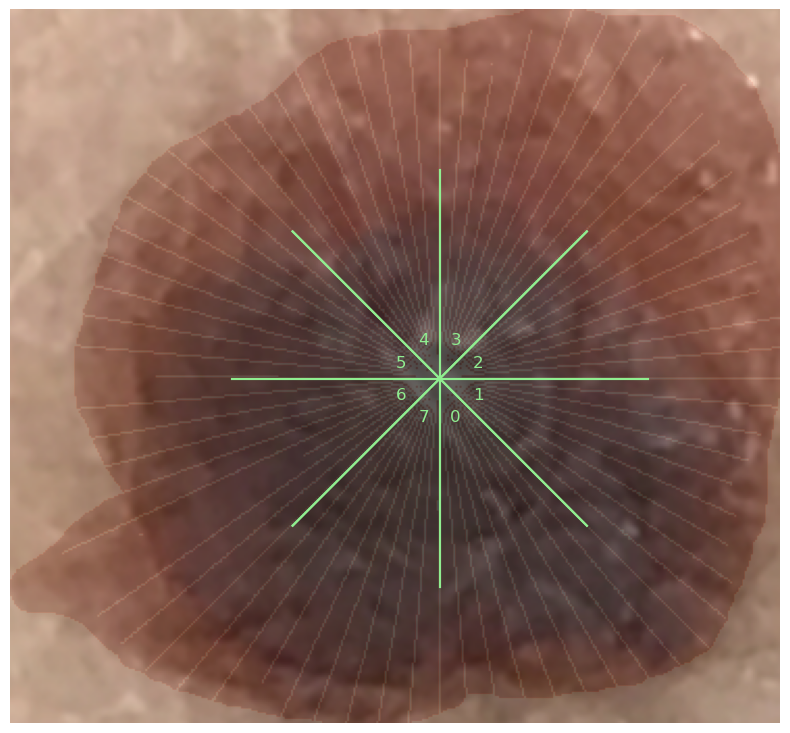

[7.5, 6.75, 7.95, 6.35, 6.3, 6.2, 6.85, 6.2]
Irregular Border: 54.1


In [253]:
def draw_sector_overlay(image, center, nSectors, line_color='lightgreen'):
    """
    Overlay sector boundary lines and labels on the image.

    :param image: 2D (grayscale) or 3D (color) image as NumPy array.
    :param center: (x, y) tuple of the center point.
    :param radius: Length of the radial lines (in pixels).
    :param sector_angles_deg: List of (start_deg, end_deg) for each sector.
    :param line_color: Color of the overlay lines (default: light green).
    """
    rad = 100

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    cx, cy = center

    sectorDeg = 360 / nSectors
    for i in range(nSectors):
        #calculate ending and starting degree
        theta_start = (np.pi/2) - np.deg2rad(i*sectorDeg)
        theta_end = (np.pi/2) - np.deg2rad((i+1)*sectorDeg)

        # Draw boundary lines
        for theta in [theta_start, theta_end]:#basically just go over the two items in the list
            x_end = cx + rad * np.cos(theta)
            y_end = cy + rad * np.sin(theta)
            ax.plot([cx, x_end], [cy, y_end], color=line_color, linewidth=1.5)

        # Place label in the center of the sector
        mid_theta = (theta_start + theta_end) / 2
        x_label = cx + (rad * 0.2) * np.cos(mid_theta)
        y_label = cy + (rad * 0.2) * np.sin(mid_theta)
        ax.text(x_label, y_label, str(i), color='lightgreen', fontsize=12, ha='center', va='center')

    ax.set_axis_off()
    plt.tight_layout()
    #plt.show()

def sample_along_line_until_border(image, mask, center, angle_rad, max_length=200, step=1.0):
    """
    Sample pixel intensities along a radial line from the center until the lesion border is reached.
    
    :param image: Grayscale image (2D array).
    :param mask: Binary lesion mask (same shape as image).
    :param center: Tuple (cx, cy) in image coordinates.
    :param angle_rad: Angle in radians to sample along.
    :param max_length: Maximum length to sample outward (safety limit).
    :param step: Step size (in pixels) along the line.
    :return: 1D array of sampled intensities along the line inside the lesion.
    """
    cx, cy = center
    sampled_values = []
    
    zeroCount = 0
    for d in np.arange(0, max_length, step):
        x = cx + d * np.cos(angle_rad)
        y = cy + d * np.sin(angle_rad)

        # Clip to image boundaries
        if x < 0 or x >= mask.shape[0] or y < 0 or y >= mask.shape[1]:
            break

        # Use bilinear interpolation to sample intensity
        px = cv2.getRectSubPix(image, (1, 1), (x, y))[0, 0]
        mx = cv2.getRectSubPix(mask.astype(np.uint8), (1, 1), (x, y))[0, 0]
        if mx == 0:
            zeroCount += 1
        if zeroCount > 20:
            break#reached the outside of the mask

        sampled_values.append(px)
        x = int(np.floor(x))
        y = int(np.floor(y))
        mask[x, y] = 0

    return np.array(sampled_values)

def analyze_sector_gradients(image, mask, center, angle_start, angle_end, lines_per_sector=10):
    """
    Analyze gradient change along radial slices within a sector.
    Returns the average of max gradients across the slices.
    """
    start_rad = np.radians(angle_start)
    end_rad = np.radians(angle_end)
    angle_range = np.linspace(start_rad, end_rad, lines_per_sector)
    center_cv = (center[1], center[0])
    max_gradients = []

    for angle in angle_range:
        intensities = sample_along_line_until_border(image, mask, center_cv, angle)
        gradients = np.abs(np.gradient(intensities))  # 1D gradient
        max_gradients.append(np.max(gradients))

    return np.mean(max_gradients)

def irregularBorder(img, mask, nSectors=8) -> int:
    """Extract the \"irregular Boder\" feature,
    which is a number from 0 to 1 that is a measure
    for the difference between the center intensity
    and border intensity of the lesion.
    
    :param img: the image to process
    :param mask: mask to apply to the image
    :return: border irregularity measure from
    0(regular) to 1(irregular)"""
    #Preprocess: Apply a gaussean blur
    img = cv2.GaussianBlur(img, ksize=(3, 3), sigmaX=0)

    cutImg = cut_im_by_mask(img, mask)
    cutImgGray = cv2.cvtColor(cutImg, cv2.COLOR_RGB2GRAY)#convert image to grayscale for gradient analysis
    cutMask = cut_mask(mask)
    mX, mY = find_midpoint_v4(cutMask)

    #store max gradient values for the sectors
    gradScores = []

    sectorDeg = int(np.ceil(360 / nSectors))
    for deg in range(0, 360, sectorDeg):
        #analyze gradient in this sector
        avgMaxGrad = analyze_sector_gradients(cutImgGray, cutMask, (mX, mY), deg, deg+sectorDeg)

        gradScores.append(avgMaxGrad)


    draw_sector_overlay(cutImg, (mX, mY), nSectors)
    plt.imshow(cutMask, cmap="Reds", alpha=0.1)
    plt.axis("off")
    plt.show()

    print(gradScores)
    return sum(gradScores)


#imName = "PAT_72_110_647.png"
#imName = "PAT_20_30_44.png"
#imName = "PAT_83_126_820.png"
#imName = "PAT_90_138_369.png"#good test case to show where it goes wrong -> if the mask doesn't fit properly, then it's fucked -> too high
#imName = "PAT_173_268_1000.png"#another example of a not-so spot on mask -> too high
#imName = "PAT_187_287_482.png"#kinda okay
#imName = "PAT_320_681_410.png"#kinda okay
#imName= "PAT_333_702_840.png"
#imName = "PAT_364_748_278.png"
#imName = "PAT_398_799_163.png"
imName = "PAT_615_1167_722.png"
maskName = imName.split(".")[0] + "_mask" + ".png"
testImg = cv2.imread(os.path.join(imgDir, imName))
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
testMask = cv2.imread(os.path.join(maskDir, maskName), cv2.IMREAD_GRAYSCALE)
_, testMask = cv2.threshold(testMask, 127, 255, cv2.THRESH_BINARY)

print(f"Irregular Border: {irregularBorder(testImg, testMask)}")

# Approach 3(original approach):
### Extract mask for center pixels and border pixels in each of the 8 segments. Compute euclidean distance of S (saturation) and V(brightness) of the center pixels to the center pixels. The idea is that the border regions with a well-pronounced edge should be less different from the center than the regions with faded edges (but maybe that was a wrong assumption from the start) -> I think this approach is pretty hopeless

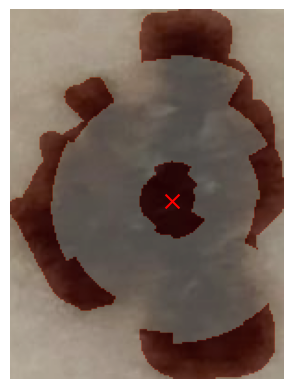

Irregular Border: 14.30492115293005


In [254]:
def irregularBorder(img, mask, nSectors=12) -> int:
    """Extract the \"irregular Boder\" feature,
    which is a number from 0 to 1 that is a measure
    for the difference between the center intensity
    and border intensity of the lesion.
    
    :param img: the image to process
    :param mask: mask to apply to the image
    :return: border irregularity measure from
    0(regular) to 1(irregular)"""
    cutImg = cut_im_by_mask(img, mask)
    cutMask = cut_mask(mask)
    mX, mY = find_midpoint_v4(cutMask)

    #prepare image for comparison of areas:
    imgHSV = cv2.cvtColor(cutImg, cv2.COLOR_RGB2HSV)
    _, s, v = cv2.split(imgHSV)

    #store distanceScores
    distScores = []

    testMask = np.zeros(cutMask.shape, dtype=np.uint8)


    sectorDeg = int(np.ceil(360 / nSectors))
    for deg in range(0, 360, sectorDeg):
        sectorMask = (getSectorMask(cutMask, deg, deg+sectorDeg, mX, mY) & cutMask)#extract current sector (only where lesion is)
        #extract only border points and then only center points in that sector
        y_nonzero, x_nonzero = np.nonzero(sectorMask)#get vectors of x-values & y-values of nonzero points (x&y reversed by numpy)
        dX = x_nonzero - mX#get vector of x-distances from points to middle
        dY = y_nonzero - mY#get vector of y-distances from points to middle
        dist = np.sqrt(dX**2 + dY**2)#compute distances for all of these points
        maxDist = np.max(dist)#get maximum distance
        distFar = maxDist*0.75#set inner threshold for border pixels
        idcBorder = np.where(dist > distFar)#extract indices for points that exceed the distance threshold
        borderMask = np.zeros(cutMask.shape, dtype=np.uint8)#create mask for border pixels
        borderMask[y_nonzero[idcBorder], x_nonzero[idcBorder]] = 1#use index obtained earlier to obtain coordinates of points exceeding the distance (again, x&y reversed because of numpy)


        testMask[y_nonzero[idcBorder], x_nonzero[idcBorder]] = 1#test mask


        #now extract the points close to the center:
        distClose = maxDist*0.2#set upper threshold for center pixels
        idcCenter = np.where(dist < distClose)
        centerMask = np.zeros(cutMask.shape, dtype=np.uint8)
        centerMask[y_nonzero[idcCenter], x_nonzero[idcCenter]] = 1


        testMask[y_nonzero[idcCenter], x_nonzero[idcCenter]] = 1#test mask


        #compute s & v means for the border and center region and then compute euclidean distance between the two regions
        avgSVBorder = np.array([np.mean(s[borderMask]), np.mean((v[borderMask]))]) * 255
        avgSVCenter = np.array([np.mean(s[centerMask]), np.mean((v[centerMask]))]) * 255
        distScores.append(np.linalg.norm(avgSVBorder - avgSVCenter))#compute euclidean distance

    plt.imshow(cutImg)
    plt.imshow(testMask, cmap="Reds", alpha=0.3)
    plt.scatter(mX, mY, c="red", marker="x", s=100)
    plt.axis("off")
    plt.show()

    return np.mean(distScores)


#imName = "PAT_72_110_647.png"
#imName = "PAT_20_30_44.png"
#imName = "PAT_83_126_820.png"
#imName = "PAT_90_138_369.png"#good test case to show where it goes wrong -> if the mask doesn't fit properly, then it's fucked -> too high
#imName = "PAT_173_268_1000.png"#another example of a not-so spot on mask -> too high
#imName = "PAT_187_287_482.png"#kinda okay
#imName = "PAT_320_681_410.png"#kinda okay
imName= "PAT_333_702_840.png"
#imName = "PAT_364_748_278.png"
maskName = imName.split(".")[0] + "_mask" + ".png"
testImg = cv2.imread(os.path.join(imgDir, imName))
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
testMask = cv2.imread(os.path.join(maskDir, maskName), cv2.IMREAD_GRAYSCALE)
_, testMask = cv2.threshold(testMask, 127, 255, cv2.THRESH_BINARY)

print(f"Irregular Border: {irregularBorder(testImg, testMask)}")

# Approach 4:
### Get the outer part of each sector and compute the maximum gradient in that area. Areas with a higher maximum gradient should have sharper edges and thus be more well-pronounced. It is similar to the line-approach, just a bit simpler/naive. I think this can suffer a great deal from some random pixels that have a high-gradienet, so I thought maybe the gaussean blurr can fix it but it doesn't do much.

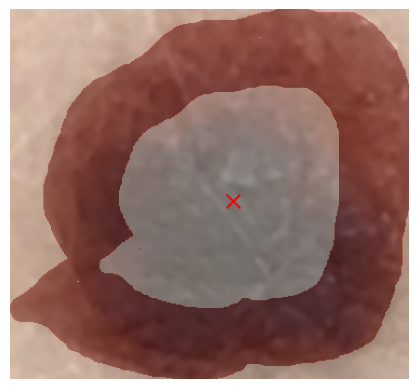

[120.5404496424333, 116.06894502837527, 89.55445270895244, 55.71355310873648, 70.0, 71.56814934033156, 57.30619512757761, 58.137767414994535]
Irregular Border: 638.8895123714013


In [255]:
def get_border_by_xor(mask, scaled_mask):
    """
    Get the border region between the original and scaled mask using XOR.
    
    :param mask: Original binary mask.
    :param scaled_mask: Inward-scaled binary mask.
    :return: Binary mask of border region.
    """
    border = cv2.bitwise_xor(mask, scaled_mask)
    return border

def irregularBorder(img, mask, nSectors=8) -> int:
    """Extract the \"irregular Boder\" feature,
    which is a number from 0 to 1 that is a measure
    for the difference between the center intensity
    and border intensity of the lesion.
    
    :param img: the image to process
    :param mask: mask to apply to the image
    :return: border irregularity measure from
    0(regular) to 1(irregular)"""
    threshold = 10.25

    img = cv2.GaussianBlur(img, ksize=(9, 9), sigmaX=0)

    cutImg = cut_im_by_mask(img, mask)
    #The following measures gradient magnitude. Later this magnitue will be compared against a threshold to determine for each sector
    #individually whether it is "well-defined" or not
    # Apply Sobel operator in X and Y direction
    sobelx = cv2.Sobel(cutImg, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(cutImg, cv2.CV_64F, 0, 1, ksize=3)
    # Compute gradient magnitude
    grad_mag = np.sqrt(sobelx**2 + sobely**2)

    cutMask = cut_mask(mask)
    mX, mY = find_midpoint_v4(cutMask)
    scaledMask = scale_mask(cutMask, (mX, mY), 0.6)
    borderMask = get_border_by_xor(cutMask, scaledMask)

    #store avg gradient values for the sectors
    gradScores = []

    testMask = np.zeros(cutMask.shape, dtype=np.uint8)

    sectorDeg = int(np.ceil(360 / nSectors))
    for deg in range(0, 360, sectorDeg):
        sectorMask = (getSectorMask(cutMask, deg, deg+sectorDeg, mX, mY) & cutMask)#extract current sector (only where lesion is)
        
        sectorBorderMask = np.logical_and(sectorMask, borderMask)
        testMask[sectorBorderMask] = 1#test mask for visualization
        max_grad = np.max(grad_mag[sectorBorderMask])
        gradScores.append(max_grad)

    plt.imshow(cutImg)
    plt.imshow(testMask, cmap="Reds", alpha=0.3)
    plt.scatter(mX, mY, c="red", marker="x", s=100)
    plt.axis("off")
    plt.show()

    print(gradScores)
    return sum(gradScores)


#imName = "PAT_72_110_647.png"
#imName = "PAT_20_30_44.png"
#imName = "PAT_83_126_820.png"
#imName = "PAT_90_138_369.png"#good test case to show where it goes wrong -> if the mask doesn't fit properly, then it's fucked -> too high
#imName = "PAT_173_268_1000.png"#another example of a not-so spot on mask -> too high
#imName = "PAT_187_287_482.png"#kinda okay
#imName = "PAT_320_681_410.png"#kinda okay
#imName= "PAT_333_702_840.png"
#imName = "PAT_364_748_278.png"
#imName = "PAT_398_799_163.png"
imName = "PAT_615_1167_722.png"
maskName = imName.split(".")[0] + "_mask" + ".png"
testImg = cv2.imread(os.path.join(imgDir, imName))
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
testMask = cv2.imread(os.path.join(maskDir, maskName), cv2.IMREAD_GRAYSCALE)
_, testMask = cv2.threshold(testMask, 127, 255, cv2.THRESH_BINARY)

print(f"Irregular Border: {irregularBorder(testImg, testMask)}")